# Linear Regression Implementation from Scratch

After getting some background on linear regression, we are now ready for a hands-on implementation. While a powerful deep learning framework minimizes repetitive work, relying on it too much to make things easy can make it hard to properly understand how deep learning works. This matters in particular if we want to change things later, e.g. define our own layers, loss functions, etc. Because of this, we start by describing how to implement linear regression training using only numpy array.

Before we begin, let's import the package or module required for this section's experiment; `matplotlib` will be used for plotting and will be set to embed in the GUI.

In [98]:
%matplotlib inline
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

## Generating Data Sets

By constructing a simple artificial training data set, we can visually compare the differences between the parameters we have learned and the actual model parameters. Set the number of examples in the training data set as 1000 and the number of inputs (feature number) as 2. Using the randomly generated batch example feature $\mathbf{X}\in \mathbb{R}^{1000 \times 2}$, we use the actual weight $\mathbf{w} = [2, -3.4]^\top$ and bias $b = 4.2$ of the linear regression model, as well as a random noise item $\epsilon$ to generate the tag

$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon$$

The noise term $\epsilon$ (or rather each coordinate of it) obeys a normal distribution with a mean of 0 and a standard deviation of 0.01. To get a better idea, let us generate the dataset.

In [99]:
num_inputs = 2
num_examples = 1000
true_w = np.array([2, -3.4])
true_b = 4.2
features = np.random.normal(scale=1, size=(num_examples, num_inputs))
labels = np.dot(features, true_w) + true_b
labels += np.random.normal(scale=0.01, size=labels.shape)

Note that each row in `features` consists of a 2-dimensional data point and that each row in `labels` consists of a 1-dimensional target value (a scalar).

In [100]:
features[0], labels[0]

(array([-1.78696468, -2.03958203]), 7.545202279006657)

By generating a scatter plot using the second `features[:, 1]` and `labels`, we can clearly observe the linear correlation between the two.

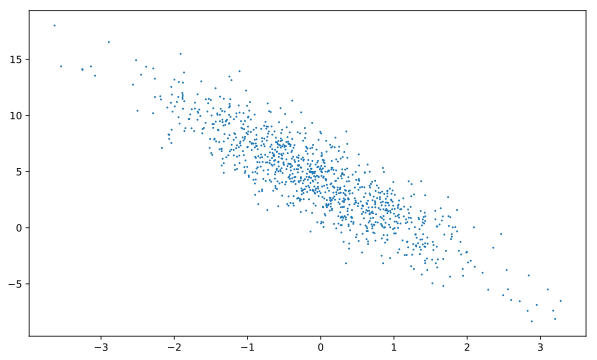

In [101]:
def use_svg_display():
    # Display in vector graphics
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # Set the size of the graph to be plotted
    plt.rcParams['figure.figsize'] = figsize

set_figsize()
plt.figure(figsize=(10, 6))
plt.scatter(features[:, 1], labels, 1);

The plotting function `plt` as well as the `use_svg_display` and `set_figsize` functions are defined in the `d2l` package. We will call `d2l.plt` directly for future plotting. To print the vector diagram and set its size, we only need to call `d2l.set_figsize()` before plotting, because `plt` is a global variable in the `d2l` package.


## Reading Data

We need to iterate over the entire data set and continuously examine mini-batches of data examples when training the model. Here we define a function. Its purpose is to return the features and tags of random `batch_size` (batch size) examples every time it's called. One might wonder why we are not reading one observation at a time but rather construct an iterator which returns a few observations at a time. This has mostly to do with efficiency when optimizing. Recall that when we processed one dimension at a time the algorithm was quite slow. The same thing happens when processing single observations vs. an entire 'batch' of them, which can be represented as a matrix rather than just a vector. In particular, GPUs are much faster when it comes to dealing with matrices, up to an order of magnitude. This is one of the reasons why deep learning usually operates on mini-batches rather than singletons.

[numpy.ndarray.take](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.ndarray.take.html#numpy-ndarray-take)

In [102]:
# This function has been saved in the d2l package for future use
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = np.array(indices[i: min(i + batch_size, num_examples)])
        ###########################################################################################
        # TODO: use the take function of numpy nd array and return the features and labels
        # at j indices in the 0 axis. The “take” function will then return the corresponding 
        # element based on the indices.
        ###########################################################################################
        x = np.take(features, j, axis = 0)
        y = np.take(labels, j, axis = 0)
        yield (x, y)
        ###########################################################################################

Let's read and print the first small batch of data examples. The shape of the features in each batch corresponds to the batch size and the number of input dimensions. Likewise, we obtain as many labels as requested by the batch size.

In [103]:
batch_size = 10

k= data_iter(batch_size, features, labels)

In [104]:
next(k)

(array([[ 0.36949587, -0.9969302 ],
        [-0.47747742, -1.21611813],
        [-1.12109678,  0.28902907],
        [-0.14158041,  0.56957793],
        [-1.45585332, -0.88749152],
        [ 0.51265649,  0.72360044],
        [ 2.89226168, -0.38933145],
        [-0.22933326, -1.00258525],
        [ 1.89866354, -0.70419334],
        [ 0.50011351, -0.98884584]]),
 array([ 8.32666171,  7.38677044,  0.96331807,  1.99008121,  4.2930807 ,
         2.7722888 , 11.32249782,  7.16403199, 10.38113757,  8.57478453]))

In [105]:
for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

[[-1.11583132  0.02988542]
 [-0.13451122  0.25037673]
 [ 0.08712862  0.81394322]
 [-1.78696468 -2.03958203]
 [ 0.13929559 -0.46864897]
 [-0.08931814 -0.15597827]
 [-0.73950618  0.36584546]
 [-1.39663382  0.05483867]
 [ 0.09199839 -1.03840667]
 [ 0.3105989   0.83246264]] [1.86651304 3.07756    1.61420416 7.54520228 6.08488597 4.55312537
 1.48148561 1.22665295 7.91943455 1.99406433]


In [106]:
k.__next__()

(array([[-0.20634369,  0.37656872],
        [ 0.21530021, -1.68094439],
        [-0.25596097,  0.6244988 ],
        [ 1.38091119,  0.60095366],
        [ 1.25066669,  0.23451083],
        [-0.31762796,  1.36143563],
        [-1.09349165,  0.73492307],
        [-0.71492247,  0.04869763],
        [-0.87752925,  0.10752367],
        [-0.89617005, -1.18710124]]),
 array([ 2.52195926, 10.3448665 ,  1.55901214,  4.91584273,  5.88553925,
        -1.06096262, -0.49130896,  2.5999014 ,  2.08347112,  6.43936438]))

Clearly, if we run the iterator again, we obtain a different minibatch until all the data has been exhausted (try this). Note that the iterator described above is a bit inefficient (it requires that we load all data in memory and that we perform a lot of random memory access). The built-in iterators are more efficient and they can deal with data stored on file (or being fed via a data stream).

## Initialize Model Parameters

Weights are initialized to normal random numbers using a mean of 0 and a standard deviation of 0.01, with the bias $b$ set to zero.

In [107]:
w = np.random.normal(scale=0.01, size=(num_inputs, 1))
b = np.zeros(shape=(1,))

In [108]:
w, b

(array([[-0.00278765],
        [-0.00463177]]), array([0.]))

## Define the Model

Next we'll want to define our model. In this case, we'll be working with linear models, the simplest possible useful neural network. To calculate the output of the linear model, we simply multiply a given input with the model's weights $w$, and add the offset $b$.

[numpy.ndarray.dot](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.dot.html)

In [109]:
# This function has been saved in the d2l package for future use
def linreg(X, w, b):
    ###########################################################################################
    # TODO: use the dot function to define the model of w * X + b, mind the dimension.
    ###########################################################################################
    k = np.dot(X, w)
    return (k + b)
    ###########################################################################################

## Define the Loss Function

We will use the squared loss function described in the previous section to define the linear regression loss. In the implementation, we need to transform the true value `y` into the predicted value's shape `y_hat`. The result returned by the following function will also be the same as the `y_hat` shape.

In [110]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## Define the Optimization Algorithm

Linear regression actually has a closed-form solution. However, most interesting models that we'll care about cannot be solved analytically. So we'll solve this problem by stochastic gradient descent `sgd`. At each step, we'll estimate the gradient of the loss with respect to our weights, using one batch randomly drawn from our dataset. Then, we'll update our parameters a small amount in the direction that reduces the loss. Here, the gradient calculated by the automatic differentiation module is the gradient sum of a batch of examples. We divide it by the batch size to obtain the average. The size of the step is determined by the learning rate `lr`.

In [111]:
# This function has been saved in the d2l package for future use
def sgd(lr, batch_size, w_grad, b_grad):
    global w, b
    w = w - lr * w_grad / batch_size
    b = b - lr * b_grad / batch_size

## Training

In training, we will iterate over the data to improve the model parameters. In each iteration, the mini-batch stochastic gradient is calculated by first calling the inverse function `backward` depending on the currently read mini-batch data examples (feature `X` and label `y`), and then calling the optimization algorithm `sgd` to iterate the model parameters. Since we previously set the batch size `batch_size` to 10, the loss shape `l` for each small batch is (10, 1).

* Initialize parameters $(\mathbf{w}, b)$
* Repeat until done
    * Compute gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{\mathcal{B}} \sum_{i \in \mathcal{B}} l(\mathbf{x}^i, y^i, \mathbf{w}, b)$
    * Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

Since nobody wants to compute gradients explicitly (this is tedious and error prone) we use automatic differentiation to compute $g$. See section ["Automatic Gradient"](../chapter_prerequisite/autograd.md) for more details. Since the loss `l` is not a scalar variable, running `l.backward()` will add together the elements in `l` to obtain the new variable, and then calculate the variable model parameters' gradient.

In an epoch (a pass through the data), we will iterate through the `data_iter` function once and use it for all the examples in the training data set (assuming the number of examples is divisible by the batch size). The number of epochs `num_epochs` and the learning rate `lr` are both hyper-parameters and are set to 3 and 0.03, respectively. Unfortunately in practice, the majority of the hyper-parameters will require some adjustment by trial and error. For instance, the model might actually become more accurate by training longer (but this increases computational cost). Likewise, we might want to change the learning rate on the fly. We will discuss this later in the chapter on ["Optimization Algorithms"](../chapter_optimization/index.md).

In [112]:
lr = 0.03  # Learning rate
num_epochs = 3  # Number of iterations
net = linreg  # Our fancy linear model
loss = squared_loss  # 0.5 (y-y')^2

for epoch in range(num_epochs):
    # Assuming the number of examples can be divided by the batch size, all
    # the examples in the training data set are used once in one epoch
    # iteration. The features and tags of mini-batch examples are given by X
    # and y respectively
    for X, y in data_iter(batch_size, features, labels):
        y_hat = net(X, w, b)
        l = loss(y_hat, y)  # Minibatch loss in X and y
        ###########################################################################################
        # TODO: use the dot function to compute the gradient of the weights 
        # Hint: multiply X.T with (y_hat - y.reshape(y_hat.shape))
        ###########################################################################################
        w_grad =  np.dot(X.T, (y_hat - y.reshape(y_hat.shape)))
        ###########################################################################################
        b_grad = (y_hat - y.reshape(y_hat.shape)).sum()
        sgd(lr, batch_size, w_grad, b_grad)  # Update parameters using their gradient
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean()))

epoch 1, loss 0.030571
epoch 2, loss 0.000122
epoch 3, loss 0.000048


To evaluate the trained model, we can compare the actual parameters used with the parameters we have learned after the training has been completed. They are very close to each other.

In [113]:
print('Error in estimating w', true_w - w.reshape(true_w.shape))
print('Error in estimating b', true_b - b)

Error in estimating w [ 0.00011605 -0.00015038]
Error in estimating b [5.1984558e-05]


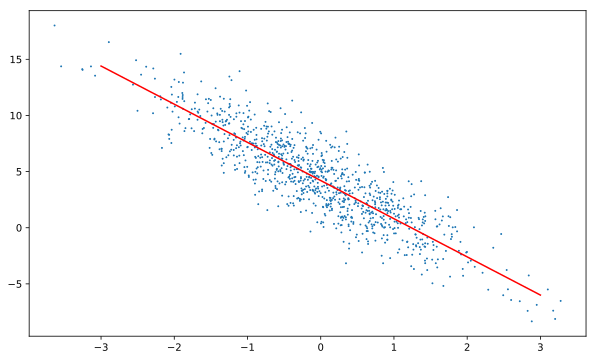

In [114]:
set_figsize()
plt.figure(figsize=(10, 6))
plt.scatter(features[:, 1], labels, 1)

x = np.linspace(-3, 3, num=10)
pred = net(x.reshape((10, 1)), w[1], b)
plt.plot(x, pred, 'r');

Note that we should not take it for granted that we are able to reover the parameters accurately. This only happens for a special category problems: strongly convex optimization problems with 'enough' data to ensure that the noisy samples allow us to recover the underlying dependency correctly. In most cases this is *not* the case. In fact, the parameters of a deep network are rarely the same (or even close) between two different runs, unless everything is kept identically, including the order in which the data is traversed. Nonetheless this can lead to very good solutions, mostly due to the fact that quite often there are many sets of parameters that work well.

## Summary

We saw how a deep network can be implemented and optimized from scratch, using just numpy array without any need for defining layers, fancy optimizers, etc. This only scratches the surface of what is possible. In the following sections, we will describe additional deep learning models based on what we have just learned and you will learn how to implement them using more concisely.